# Demonstration notebook for evaluation and results
This is a self contained notebook with intermediate files generated to aid the evaluation process.

The models are trained and uploaded to huggingface, and loaded in the notebook.

5000 poems are generated using the RL and the baseline model.

The evaluation process for sentiment accuracy (30min) and fluency (40min) can be a little slow depending on the computing power.

We used google colab pro for faster computation and larger GPU memory. If there is an memory error, please refer to the notes in each section for fixing, or run torch.cuda.empty_cache().

# Imports

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
!pip install transformers datasets language_tool_python scipy matplotlib numpy pandas torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import numpy as np
import pandas as pd
import torch
from itertools import compress
import language_tool_python
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer, pipeline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda")
torch.cuda.empty_cache()

# Helper functions

In [4]:
def load_evaluation_prompts(length=5, seed=19019509):
    """
    load one prompt from each emotion
    length:  length of the prompt
    """
    PERC_path = "./PERC.csv"
    rng = np.random.default_rng(seed)
    dataset = pd.read_csv(PERC_path)
    Emotions = list(set(dataset['Emotion']))
    Emotions.sort()
    Prompts = {}
    for emotion in Emotions:
        mask = dataset["Emotion"] == emotion
        prompt = rng.choice(dataset[mask])[0]
        Prompts[emotion] = ' '.join(prompt.split()[:length])
    return Prompts

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
def generation(tokenizer, model, encoded_prompt, save_path, iteration=20):
    """
    generate 5000 texts to file with baseline model
    """
    generation_length = 100
    f = open(save_path, "a", encoding="utf-8")
    for i in range(iteration):
        print(i+1, "/", iteration)
        set_seed(i)
        generation_kwargs = {
            "max_length": generation_length + len(encoded_prompt[0]),
            "top_k": 50,
            "num_return_sequences": 250,
            "top_p": 0.9,
            "do_sample": True,
            "repetition_penalty": 1.0
        }
        output_sequences = model.generate(input_ids=encoded_prompt, **generation_kwargs)
        if len(output_sequences.shape) > 2:
                output_sequences.squeeze_()

        generated_sequences = []

        for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
            f.write(f"\n=== GENERATED SEQUENCE {generated_sequence_idx + 1} ===\n")
            generated_sequence = generated_sequence.tolist()

            # Decode text
            text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

            # Add the prompt at the beginning of the sequence. Remove the excess text that was used for pre-processing
            total_sequence = (
                joy + text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)) :]
            )

            generated_sequences.append(total_sequence)
            f.write(total_sequence)
    f.close()

In [6]:
def _read_text(path):
    """
    read in the generated text and remove excess
    """
    with open(path, encoding="utf8") as f:
        lines = [line.strip() for line in f]

    phrases = []
    phrase = ""
    for x in lines:
        if x.startswith("==="):
            phrases.append(phrase)
            phrase = ""
            continue
        phrase = phrase + x
    return phrases

def fluency(path = "./baseline_generation.txt", verbose = 0, size=None):
    """
    Give a score on the average fluency and fluency distribution

    Returns:
            error rate: single float over all phrases
            error rates: array of float for each phrase
    """
    phrases = _read_text(path)
    rng = np.random.default_rng()
    if size != None:
        indices = rng.choice(len(phrases), size)
        phrases = [phrases[index] for index in indices]
    print(len(phrases), " phrases")

    # mask = [not x.startswith("===") for x in lines]
    # sentences = list(compress(lines, mask))   
    # check grammar error rate from the language tool
    tool = language_tool_python.LanguageTool("en-US")
    total_length = 0
    total_errors = 0
    error_rate = 0
    error_rates = []
    counter = 0
    for phrase in phrases:
        try:
            if verbose >= 1:
                counter += 1
                print(counter)
            length = len(phrase.split())
            total_length += length
            matches = tool.check(phrase)
            error_counter = 0
            for i in matches:
                if i.ruleId == "WHITESPACE_RULE" or i.ruleId == "PRP_COMMA" or i.ruleId == "COMMA_COMPOUND_SENTENCE":
                    continue
                error_counter += 1
            naive_errors = error_counter
            total_errors += naive_errors
            if length > 0:
                error_rates.append(1-naive_errors/length)
        except KeyboardInterrupt:
            break
    tool.close()
    error_rate = 1-total_errors/total_length
    return error_rate, error_rates

def diversity(path = "./baseline_generation.txt", seed=None, size = 50):
    """
    Diversity between {size} phrases
    path: the path of the generated txt file containing the phrases
    seed: for reproducibility
    """
    tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model.to(device)
    # Tokenize input texts
    texts = _read_text(path=path)
    rng = np.random.default_rng()
    if seed != None:
        rng = np.random.default_rng(seed=seed)
    indices = rng.choice(len(texts), size=size, replace=False)
    print("selecting indices: ", indices)
    texts = [texts[index] for index in indices]
    texts = [' '.join(text.split()[5:]) for text in texts]

    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    inputs.to(device)
    # Get the embeddings
    with torch.no_grad():
        embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.cpu()

    # Calculate cosine similarities
    # results are in [0, 1]. Higher means more diversity
    cos_sim_mat = []
    for i in range(embeddings.shape[0]):
        print(i+1, "/", size)
        for j in range(embeddings.shape[0]):
            if i >= j:
                continue
            cos_sim = cosine(embeddings[i], embeddings[j])/2
            cos_sim_mat.append(cos_sim)
    return cos_sim_mat

def accuracy_smooth(path = "./baseline_generation.txt", size = None, metric=1):
    """
    Calculate the sentiment accuracy score for a generation file
    """
    phrases = _read_text(path)
    rng = np.random.default_rng()
    if size != None:
        indices = rng.choice(len(phrases), size)
        phrases = [phrases[index] for index in indices]
    print(len(phrases), " phrases")
    model = 'cardiffnlp/twitter-roberta-base-sentiment' if metric == 1 else 'nickwong64/bert-base-uncased-poems-sentiment'
    nlp = pipeline(task='text-classification', model=model, top_k=None)
    results = nlp(phrases)
    scores = [labels['score'] for result in results for labels in result if labels['label'] == 'LABEL_2']
    neg_scores = [labels['score'] for result in results for labels in result if labels['label'] == 'LABEL_0']
    return scores, neg_scores

def novelty_new(training_phrase, path = "./baseline_generation.txt", seed=None, size = 50, start=None, prompt_size=5):
    """
    Novelty between {size} phrases and the trainning phrase
    training_phrase: the phrase used in the training dataset with the same prompt as the generated phrases
    path: the path of the generated txt file containing the phrases
    seed: for reproducibility
    start: select in order, seed is not used if start != None
    """
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model.to(device)
    # Tokenize input texts
    texts = _read_text(path=path)
    if start == None:
        rng = np.random.default_rng()
        if seed != None:
            rng = np.random.default_rng(seed=seed)
        index = rng.choice(len(texts))
    else:
        index = start if start+size < len(texts) else 0
    texts = texts[index:index+size]
    texts.append(training_phrase)
    texts = [' '.join(text.split()[5:]) for text in texts]

    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    inputs.to(device)
    # Get the embeddings
    with torch.no_grad():
        embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.cpu()

    # Calculate cosine similarities
    # results are in [0, 1]. Higher means more diversity
    cos_sim_mat = []
    for i in range(embeddings.shape[0]-1):
            cos_sim = cosine(embeddings[i], embeddings[-1])/2
            cos_sim_mat.append(cos_sim)
    del texts
    del embeddings
    del model
    del inputs
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    return cos_sim_mat


# Data

In [7]:
data_name = "COMP0087-GROUP8-22-23/PERC"
PERC_path = "./PERC.csv"
dataset = load_dataset(data_name)
data = dataset['train']
data.to_csv(PERC_path)
print(list(set(data['Emotion'])))

  0%|          | 0/1 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

['sad', 'joy', 'hate', 'anger', 'fear', 'peace', 'courage', 'love', 'surprise']


In [8]:
set_seed(0)
prompts = load_evaluation_prompts(seed=1234567)
joy = prompts["joy"]
# this is for novelty evaluation
original = load_evaluation_prompts(seed=1234567, length=-1)
joy_original = original["joy"]
print("Using prompt: ", joy, " original sentence: \n", joy_original)

Using prompt:  To My Fairy Fancies NAY,  original sentence: 
 To My Fairy Fancies NAY, no longer I may hold you, In my spirit's soft caresses, Nor like lotus-leaves enfold you In the tangles of my tresses. Fairy fancies, fly away To the white cloud-wildernesses, Fly away! Nay, no longer ye may linger With your laughter-lighted faces, Now I am a thought-worn singer In life's high and lonely places. Fairy fancies, fly away, To bright wind-inwoven spaces, Fly


# Baseline generation
Look at file "./baseline_generation.txt" for other examples of generated text

In [9]:
model_name = "COMP0087-GROUP8-22-23/GPT2-poem-baseline"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)
encoded_prompt = tokenizer.encode(joy, add_special_tokens=False, return_tensors="pt")
encoded_prompt = encoded_prompt.to(device)

In [10]:
generation(tokenizer=tokenizer, model=model, encoded_prompt=encoded_prompt, save_path="./baseline_generation.txt", iteration=20)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


10 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


11 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


12 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


13 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


14 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


18 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


19 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20 / 20


# Baseline evaluation

## Sentiment accuracy

5000  phrases
0.4102119948732201 0.2796032066606219


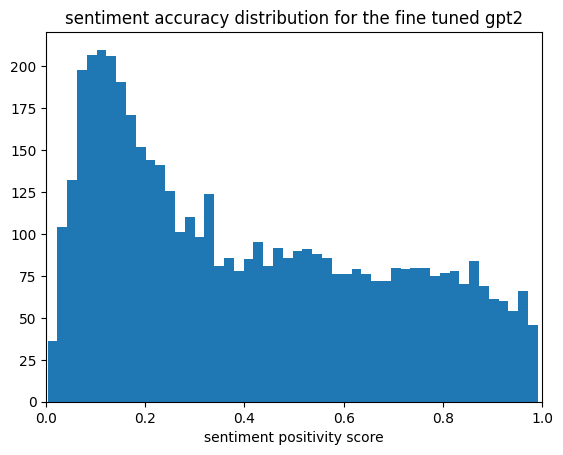

In [22]:
pos_score, neg_score = accuracy_smooth()
print(np.mean(pos_score), np.std(pos_score))
plt.figure()
plt.hist(pos_score, bins=50)
plt.title("sentiment accuracy distribution for the fine tuned gpt2")
plt.xlim(0, 1)
plt.xlabel("sentiment positivity score")
plt.show()

## Diversity

selecting indices:  [3016  499 4377 4052 3488 4117 4752 2718   78 2806 1279 3042 4190 4502
 4355 1396 1719 2011 2500 4628 2914 2423 4715 3364 4431 1190  347  253
 3983 4330  841 3343 2206 2259 4978 2033 2427 3823 4087 2945 4691  424
  911 2579 2505  159 2385 3719 4847 2341 2311 4342  282 2618  861 1699
   22  498  626 3731 1394 3309 3033 1203  668 3555  776 3299 4681 4593
 4683  966  536  760 2312 4011 1492 2273 4987 2825 4620 2407 4480 2372
 3515 4839 2435 2276 1041 2013 2554 3388  480 2886 3218 4366 4555 3929
 4668  930 4631  374 3456 2629  244 2640  143 3203 2149 4590 3475 2422
 2631   26 1187  226 1341  350 1235 1504 1319  461 2081  941 4481 3759
  124 3992  472 4652 4098 3054 3849  932 1546 3177 2846 3989 2892  816
 1480 1756 1791 3867 3895 2269 1221 1881   35 4256 4771   95 4613  482
  606 4570 3523 1080  147 2207 2379 2289 2144 4867 4385 3360 4528  509
 2243  165 3328 4474 4994 1837 2428 3589  982 4559 4641  838 1689  127
 1209 1269 4909  979 3569  609 2852 4327 4273 3886 2897 2

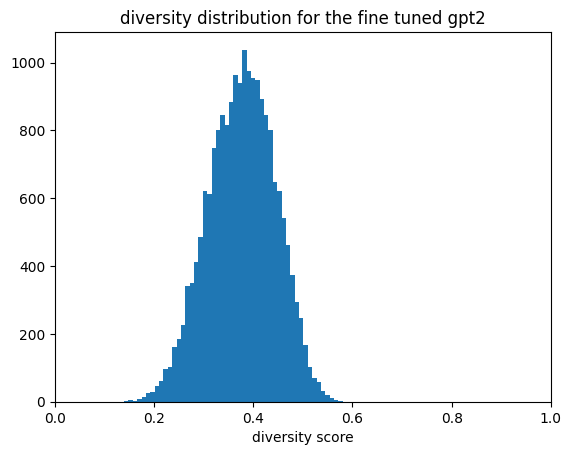

In [12]:
diversity_score = diversity(size=200)
print(np.mean(diversity_score), np.std(diversity_score))
plt.figure()
plt.hist(diversity_score, bins=50)
plt.title("diversity distribution for the fine tuned gpt2")
plt.xlabel("diversity score")
plt.xlim(0, 1)
plt.show()

## Novelty
If there is a memory error, change size to smaller value

In [25]:
size = 500
novelty_score = []
for i in range(int(5000/size)):
    print(i+1, "/", int(5000/size))
    novelty_score.append(novelty_new(training_phrase=joy_original, size=size, start=i*size))
    
np.savetxt('./baseline_novelty_scores.txt', novelty_score, delimiter=',') 

0
1
2
3
4
5
6
7
8
9


0.35949116676701814 0.05785492058752394


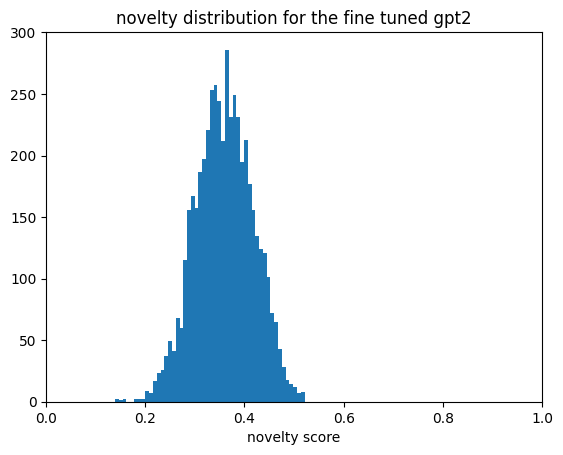

In [26]:
loaded_novelty = np.loadtxt('./baseline_novelty_scores.txt', delimiter=',') 
loaded_novelty = loaded_novelty.flatten()
loaded_novelty.shape
print(np.mean(loaded_novelty), np.std(loaded_novelty))
plt.figure()
plt.hist(loaded_novelty, bins=50)
plt.title("novelty distribution for the fine tuned gpt2")
plt.xlabel("novelty score")
plt.xlim(0,1)
plt.show()

## Fluency

please wait until 5000 phrases are analyzed, colab is slow for fluency evaluation
5000  phrases


INFO:language_tool_python.download_lt:Unzipping /tmp/tmpea4r_uf_.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to /root/.cache/language_tool_python.


Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265

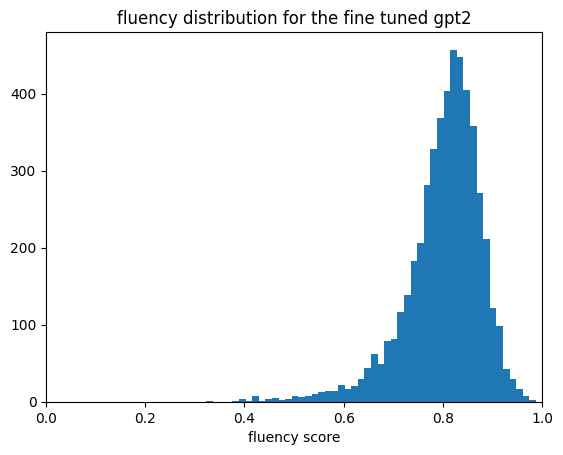

In [13]:
print("please wait until 5000 phrases are analyzed, colab is slow for fluency evaluation")
rate, rates = fluency(verbose=1)
print(np.mean(rates), np.std(rates))
plt.close()
plt.figure()
plt.hist(rates, bins=50)
plt.title("fluency distribution for the fine tuned gpt2")
plt.xlabel("fluency score")
plt.xlim(0, 1)
plt.show()

# RL generation

In [9]:
model_name = "COMP0087-GROUP8-22-23/GPT2_BERT_0.5_OUT"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)
encoded_prompt = tokenizer.encode(joy, add_special_tokens=False, return_tensors="pt")
encoded_prompt = encoded_prompt.to(device)

Some weights of the model checkpoint at COMP0087-GROUP8-22-23/GPT2_BERT_0.5_OUT were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
generation(tokenizer=tokenizer, model=model, encoded_prompt=encoded_prompt, save_path="./rl_generation.txt", iteration=20)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


10 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


11 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


12 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


13 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


14 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


18 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


19 / 20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20 / 20


# RL evaluation

## Sentiment accuracy

In [16]:
pos_score, neg_score = accuracy_smooth(path="./rl_generation.txt")
print(np.mean(pos_score), np.std(pos_score))
plt.figure()
plt.hist(pos_score, bins=50)
plt.title("sentiment accuracy distribution for the fine tuned gpt2")
plt.xlim(0, 1)
plt.xlabel("sentiment positivity score")
plt.show()

FileNotFoundError: ignored

## Diversity

selecting indices:  [5243 4153  854 5144 4148 2389 6607 4503 2313 6772 6568 2666  673 3147
  564   59 6102 4373  803 2850 4978   99 3566 2396 4552 5815 1492 6796
 3822 2667  814  630 4959 3378 1180 4091 2031 6038 5209 2484 1140 4773
 3433  203 2537 3467 2414 6304 2107 1978  455 2214 2432  805 5346 2857
 4052 6064 5960   72 1655 1500 6677 5587 4548 3374 1363 3541 3073 1310
 4998 5640 5625 6389 1592 3652 4348 6823 4975 6048 1316 2439 2474 3438
 6734 4053 5310 4519 2000 3093 5465 3658 5013 2441 6616 4414 6799 6103
 1530 3672]
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 

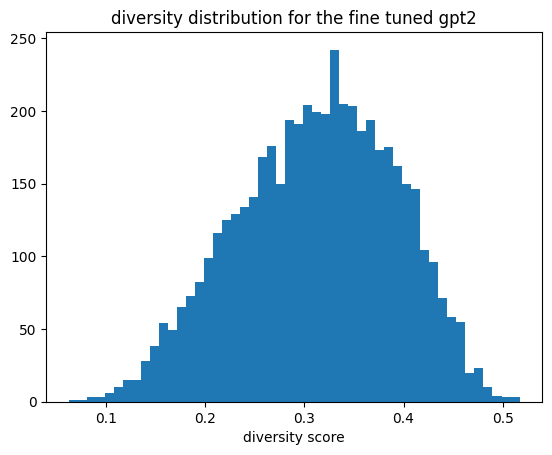

In [19]:
diversity_score = diversity(path="./rl_generation.txt", size=100)
print(np.mean(diversity_score), np.std(diversity_score))
plt.figure()
plt.hist(diversity_score, bins=50)
plt.title("diversity distribution for the fine tuned gpt2")
plt.xlabel("diversity score")
# plt.xlim(0, 1)
plt.show()

## Novelty

In [10]:
size = 500
novelty_score = []
for i in range(int(5000/size)):
    print(i+1, "/", int(5000/size))
    novelty_score.append(novelty_new(path="./rl_generation.txt", training_phrase=joy_original, size=size, start=i*size))

np.savetxt('./rl_novelty_scores.txt', novelty_score, delimiter=',') 

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


0.36846968145715076 0.04602505474454373


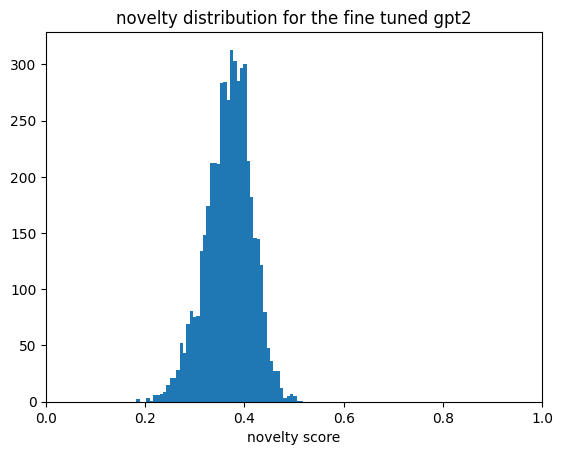

In [11]:
loaded_novelty = np.loadtxt('./rl_novelty_scores.txt', delimiter=',') 
loaded_novelty = loaded_novelty.flatten()
loaded_novelty.shape
print(np.mean(loaded_novelty), np.std(loaded_novelty))
plt.figure()
plt.hist(loaded_novelty, bins=50)
plt.title("novelty distribution for the fine tuned gpt2")
plt.xlabel("novelty score")
plt.xlim(0,1)
plt.show()

## Fluency

In [ ]:
print("please wait until 5000 phrases are analyzed, colab is slow for fluency evaluation")
rate, rates = fluency(path="./rl_generation.txt", verbose=1)
print(np.mean(rates), np.std(rates))
plt.close()
plt.figure()
plt.hist(rates, bins=50)
plt.title("fluency distribution for the fine tuned gpt2")
plt.xlabel("fluency score")
plt.xlim(0, 1)
plt.show()